# Attention

This notebook used material from the PyTorch tutorial [Language Translation with nn.Transformer and torchtext](https://pytorch.org/tutorials/beginner/translation_transformer.html).

I used Black to format the code in this notebook. If you want to contribute, use the following to format code cells upon running them.

In [51]:
# !pip install jupyter-black
import jupyter_black

jupyter_black.load(line_length=120)

## Prerequisites

If you are using Google Colaboratory, go to ```Edit / Notebook settings``` and set the hardware accelerator to ```GPU``` 

In addition to packages you've installed in previous notebooks, you'll need the natural language processing tools `tiktoken` and `datasets` from HuggingFace.

In [52]:
# !pip install tiktoken datasets

In [53]:
import base64
import copy
import psutil

from typing import Generator, Iterable

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm
import tiktoken
from datasets import load_dataset

You should use a GPU to run this notebook.

In [54]:
assert torch.cuda.is_available(), "CUDA is not available."
DEVICE = "cuda"
assert torch.cuda.get_device_properties(DEVICE).major >= 8, "CUDA with compute capability >= 8.0 is required."

# Why attention?

Attention mechanisms have become a crucial component in modern neural network architectures, particularly in the field of natural language processing (NLP). The primary motivation behind attention is to allow the model to focus on different parts of the input sequence when making predictions, rather than treating all parts of the input equally. This is especially important for tasks like machine translation, where the relevance of each word in the input sentence can vary depending on the context.

Consider the task of translating a sentence from one language to another. Traditional sequence-to-sequence models, such as those using recurrent neural networks (RNNs), process the input sequence in a fixed order and generate the output sequence one token at a time. However, these models often struggle with long sentences because they need to compress all the information from the input sequence into a fixed-size context vector. This can lead to information loss and poor performance on long sentences.

Attention mechanisms address this issue by allowing the model to dynamically focus on different parts of the input sequence at each step of the output generation. Instead of relying on a single context vector, the model computes a weighted sum of the input representations, where the weights are determined by the relevance of each input token to the current output token being generated. This allows the model to capture long-range dependencies and handle long sentences more effectively.

In the context of the Transformer architecture, attention mechanisms are used extensively in both the encoder and decoder layers. The encoder uses self-attention to capture relationships between tokens in the input sequence, while the decoder uses self-attention to capture relationships within the output sequence and cross-attention to capture relationships between the input and output sequences.

The following sections will guide you through the implementation of a Transformer model with attention mechanisms, and demonstrate how it can be used for tasks like machine translation.

# Multi-Head Attention in Transformers

Transformers have been a thing for quite a while now, and many high-quality educational materials have been developed for it. The following materials are arranged roughly in order of detail from vague to specific.
* [3Blue1Brown: Large Language Models explained briefly](https://youtu.be/LPZh9BOjkQs?si=9hE7YQ1TMp8_obOz)
* [3Blue1Brown: Attention in Transformers, visually explained](https://youtu.be/eMlx5fFNoYc?si=cAo42oOGAKAhOUZW)
* [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

It's a hot topic, so new materials are always coming out. Search around, or have a chat with the assistant of your choice.

In this notebook, you'll implement masked multi-head attention, and stick it into a Transformer, diagrammed in the following figure.

<div>
<img src="data/transformer.png" width="400"/>
</div>

(Transformer diagram from [Attention Is All You Need](https://commons.wikimedia.org/wiki/File:Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg). The Transformer is composed of an encoder shown on the left half and a decoder shown on the right half.)

We will then use the Transformer to translate German to English using the [IWSLT 2017 Multilingual Task](https://sites.google.com/site/iwsltevaluation2017/TED-tasks) dataset.

First, we will create the input embedding and output embedding layers.

<div>
<img src="data/transformer_embedding.png" width="400"/>
</div>

They take integer token indices and learn vector representations of them. They are just `nn.Embedding` modules with the output scaled by the square root of the number of elements in each vector.

In [55]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int):
        """
        :param vocab_size: Number of tokens in the token space.
        :param embed_dim: Number of elements in embedding vectors.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dim = embed_dim

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        :param tokens: Tensor of integers.
        :returns: Embeddings of tokens, shaped (*(tokens shape), embedding size)
        """
        return self.embedding(tokens) * self.embed_dim**0.5

Worth discussing with your friends:
> Why scale it by the square root of the embedding size?

Next, the positional encoding layers.

<div>
<img src="data/transformer_positional.png" width="400"/>
</div>

In ancient times, when recurrent neural networks were typically used for language translation, we didn't need to encode the positions of input tokens, since they were processed in order (front-to-back and back-to-front). We don't want to do that now because it's slow, but we still need some way to marking where in a sequence an input token occurred. There are a few ways of doing this, but the Transformer paper interleaved some scaled sine and cosine values, to be added to the embeddings.

In [56]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, dropout: float, max_length: int = 5000):
        """
        :param embed_dim: Number of elements in embedding vectors.
        :param dropout: Probability of zeroing an output element.
        :param max_length: Longest sequence length supported.
        """
        super().__init__()
        ln_10000 = 9.21034049987793
        positional_encoding = torch.zeros((max_length, embed_dim))
        positions = torch.arange(0, max_length).reshape(max_length, 1)
        scale = torch.exp(-torch.arange(0, embed_dim, 2) * ln_10000 / embed_dim)
        positional_encoding[:, 0::2] = torch.sin(positions * scale)
        positional_encoding[:, 1::2] = torch.cos(positions * scale)
        positional_encoding = positional_encoding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("positional_encoding", positional_encoding)

    def forward(self, token_embedding: torch.Tensor):
        """
        :param token_embedding: Token embeddings shaped (sequence length, batch size, embedding size)
        :returns: Embeddings with positional encoding added, possibly with some dropouts.
        """
        return self.dropout(token_embedding + self.positional_encoding[: token_embedding.size(0), :])

As an example, suppose there were embeddings of size 64, and a sequence of length 100. The following positional encodings would be added to the sequence.

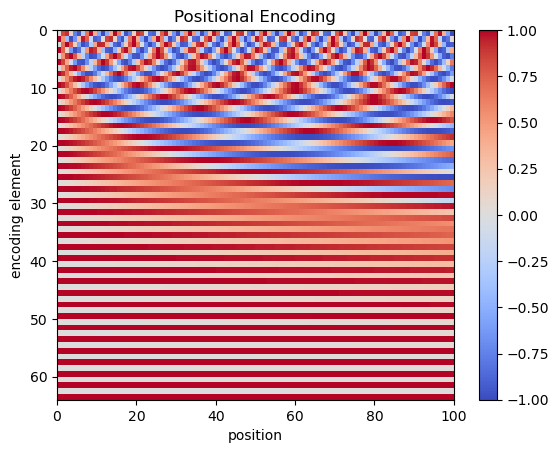

In [57]:
plt.pcolormesh(PositionalEncoding(64, 0, 100).positional_encoding[:, 0, :].permute(1, 0).numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("Positional Encoding")
plt.xlabel("position")
plt.ylabel("encoding element")
plt.gca().invert_yaxis()
plt.show()

Worth discussing with your friends:
> For encoding position, why not just use an incrementing integer or a real number that goes from 0 to 1? By the way, the most common appoach today is to use an embedding layer to encode position.

### Your turn: Implement (masked) multi-head attention.

<div>
<img src="data/transformer_attention.png" width="400"/>
</div>

Masked multi-head attention can be turned into (unmasked) multi-head attention by using it without a mask. A mask is applied in the decoder attention module to prevent attending to future tokens when predicting the current token. These attention modules sit inside an encoder or decoder layer, and such layers are composed multiple times to make an encoder or a decoder.

Inside a multi-head attention module we do the following. Look for references to these steps in the comments to help you implement it. There are things you have to write in both the constructor `__init__` and in the `forward` method.
1. We take three copies of the input embeddings (called the *query*, *key*, and *value*), and do a linear transformation on each to a typically smaller size. This is sometimes called *in-projection*. To do this, instantiate three `nn.Linear` modules in the constructor `__init__`. Then, in the `forward` method, call those instances.

1. We calculate the scaled dot product attention weights through a batched (broadcasted) matrix multiplication. The broadcast will be over all but the last two dimensions of the operands. Thus, before performing matrix multiplication, we reshape the projected query, key, and value from shape (sequence length, batch size, embedding size) to (batch size, number of heads, sequence length, head size), where head size is the embedding size divided by the number of heads. PyTorch provides some reshaping functions including `view`, `reshape`, `transpose`, and `permute`. See [this blog post](https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/) for a comparison of them. After appropriately reshaping, calculate attention weights as $\frac{Q K^T}{\sqrt{h}}$, where $Q$ is the projected query, $K$ is the projected key, and $h$ is the head size.

1. If a mask is provided, we add it to the weights. Remember that mask elements are either 0 or $-\infty$.

1. We apply softmax and dropout to the attention weights. If you prefer, you can instantiate `nn.Softmax` and `nn.Dropout` modules to do this.

1. We matrix multiply the attention weights with the projected value.

1. We concatenate all the head outputs and apply a linear transformation, called *out-projection*. At this point, the attended output is shaped (batch size, number of heads, target sequence length, head size). We should concatenate the head outputs, and reshape the batch and sequence axes into the same axis. The result should be shaped (batch size $*$ target sequence length, embedding size). Perform an out-projection on this using an `nn.Linear` module that you instantiate in the constructor. Then, reshape the output in preparation for the next layer, which expects a shape (target sequence length, batch size, embedding size).

In [58]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.0, kdim: int = None, vdim: int = None):
        """
        :param embed_dim: Size of embeddings, must be a multiple of num_heads.
        :param num_heads: Number of parallel attention heads. Each head attends to embed_dim / num_heads elements.
        :param dropout: Dropout probability on attention weights.
        :param kdim: Total number of features for keys. If None, kdim=embed_dim.
        :param vdim: Total number of features for values. If None, vdim=embed_dim.
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.dropout_probability = dropout

        # STEP 1: IN-PROJECTION
        self.query_linear = nn.Linear(self.embed_dim, self.embed_dim)
        self.key_linear = nn.Linear(self.kdim, self.embed_dim)
        self.value_linear = nn.Linear(self.vdim, self.embed_dim)
        # END STEP 1

        # STEP 6: OUT-PROJECTION
        self.out_projection = nn.Linear(self.embed_dim, self.embed_dim)
        # END STEP 6

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        key_padding_mask: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        :param query: query embeddings shaped (target sequence length, batch size, embedding size)
        :param key: key embeddings shaped (source sequence length, batch size, embedding size)
        :param value: value embeddings shaped (source sequence length, batch size, embedding size)
        :param key_padding_mask: floating-point mask shaped (batch size, source sequence length).
            This mask will be added to the attention mask before softmax.
            To ignore elements in the key embedding, put -inf in corresponding places in the mask.
        :param attention_mask: floating-point mask shaped (target sequence length, source sequence length).
            This mask will be added to the attention weights before softmax.
        :returns: tuple of (attention output, attention weight).
            Attention output is shaped (target sequence length, batch size, embedding size).
            Attention weight is shaped (batch_size, number of heads, target sequence length, source sequence length).

        Simplification of nn.functional.multi_head_attention_forward
        """

        target_length, batch_size, _ = query.shape
        source_length, _, _ = key.shape

        # STEP 1: In-projection
        projected_query = self.query_linear(query)
        projected_key = self.key_linear(key)
        projected_value = self.value_linear(value)
        # END STEP 1

        # STEP 2: Calculate attention weights
        # Need to reshape to prepare for batched matrix multiplication.
        # Reshape from (sequence length, batch size, embedding size)
        # to (batch size, number of heads, sequence length, head size)
        projected_query = (
            projected_query.view(target_length, batch_size * self.num_heads, self.head_dim)
            .transpose(0, 1)
            .view(batch_size, self.num_heads, target_length, self.head_dim)
        )
        projected_key = (
            projected_key.view(projected_key.shape[0], batch_size * self.num_heads, self.head_dim)
            .transpose(0, 1)
            .view(batch_size, self.num_heads, source_length, self.head_dim)
        )
        projected_value = (
            projected_value.view(projected_value.shape[0], batch_size * self.num_heads, self.head_dim)
            .transpose(0, 1)
            .view(batch_size, self.num_heads, source_length, self.head_dim)
        )

        attention_weight = projected_query @ projected_key.transpose(-2, -1) / projected_query.size(-1) ** 0.5
        # END STEP 2

        # STEP 3: Apply masks
        mask = self._combine_masks(key_padding_mask, attention_mask, target_length, batch_size, source_length)
        # The combined mask is shaped (batch_size, number of heads, target sequence length, source sequence length).
        if mask is not None:
            attention_weight @ projected_value
        # END STEP 3

        # STEP 4: Softmax and dropout
        attention_weight = nn.functional.dropout(
            torch.softmax(attention_weight, dim=-1), self.dropout_probability, self.training
        )
        # END STEP 4

        # STEP 5
        attended_output = attention_weight @ projected_value
        # END STEP 5

        # STEP 6
        attended_output = (
            attended_output.permute(2, 0, 1, 3).contiguous().view(batch_size * target_length, self.embed_dim)
        )
        attended_output = self.out_projection(attended_output)
        attended_output = attended_output.view(target_length, batch_size, attended_output.size(1))
        # END STEP 6

        return attended_output, attention_weight

    def _combine_masks(
        self,
        key_padding_mask: torch.Tensor,
        attention_mask: torch.Tensor,
        target_length: int,
        batch_size: int,
        source_length: int,
    ) -> torch.Tensor:
        """
        Combine and reshape the key padding mask and attention mask.
        """
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                attention_mask = attention_mask.unsqueeze(0)

        if key_padding_mask is not None:
            key_padding_mask = (
                key_padding_mask.view(batch_size, 1, 1, source_length)
                .expand(-1, self.num_heads, -1, -1)
                .reshape(batch_size * self.num_heads, 1, source_length)
            )
            if attention_mask is not None:
                attention_mask = attention_mask + key_padding_mask  # Don't say +=.

        if attention_mask is not None:
            if attention_mask.shape[0] == 1:  # batch size is 1 and there is 1 head
                attention_mask = attention_mask.unsqueeze(0)
            else:
                attention_mask = attention_mask.view(batch_size, self.num_heads, target_length, source_length)
        return attention_mask

Uncomment the following code cells to see a solution. Since there are many ways to do this, it's quite likely that these differ from your implementation, while the result is the same.

Step 1 solution:

In [59]:
print(
    base64.b64decode(
        b"SW4gX19pbml0X186CnNlbGYucXVlcnlfbGluZWFyID0gbm4uTGluZWFyKHNlbGYuZW1iZWRfZGltLCBzZWxmLmVtYmVkX2RpbSkKc2VsZi5rZXlfbGluZWFyID0gbm4uTGluZWFyKHNlbGYua2RpbSwgc2VsZi5lbWJlZF9kaW0pCnNlbGYudmFsdWVfbGluZWFyID0gbm4uTGluZWFyKHNlbGYudmRpbSwgc2VsZi5lbWJlZF9kaW0pCgpJbiBmb3J3YXJkOgpwcm9qZWN0ZWRfcXVlcnkgPSBzZWxmLnF1ZXJ5X2xpbmVhcihxdWVyeSkKcHJvamVjdGVkX2tleSA9IHNlbGYua2V5X2xpbmVhcihrZXkpCnByb2plY3RlZF92YWx1ZSA9IHNlbGYudmFsdWVfbGluZWFyKHZhbHVlKQ=="
    ).decode()
)

In __init__:
self.query_linear = nn.Linear(self.embed_dim, self.embed_dim)
self.key_linear = nn.Linear(self.kdim, self.embed_dim)
self.value_linear = nn.Linear(self.vdim, self.embed_dim)

In forward:
projected_query = self.query_linear(query)
projected_key = self.key_linear(key)
projected_value = self.value_linear(value)


Step 2 solution:

In [60]:
print(
    base64.b64decode(
        b"cHJvamVjdGVkX3F1ZXJ5ID0gKAogICAgcHJvamVjdGVkX3F1ZXJ5LnZpZXcodGFyZ2V0X2xlbmd0aCwgYmF0Y2hfc2l6ZSAqIHNlbGYubnVtX2hlYWRzLCBzZWxmLmhlYWRfZGltKQogICAgLnRyYW5zcG9zZSgwLCAxKQogICAgLnZpZXcoYmF0Y2hfc2l6ZSwgc2VsZi5udW1faGVhZHMsIHRhcmdldF9sZW5ndGgsIHNlbGYuaGVhZF9kaW0pCikKcHJvamVjdGVkX2tleSA9ICgKICAgIHByb2plY3RlZF9rZXkudmlldyhwcm9qZWN0ZWRfa2V5LnNoYXBlWzBdLCBiYXRjaF9zaXplICogc2VsZi5udW1faGVhZHMsIHNlbGYuaGVhZF9kaW0pCiAgICAudHJhbnNwb3NlKDAsIDEpCiAgICAudmlldyhiYXRjaF9zaXplLCBzZWxmLm51bV9oZWFkcywgc291cmNlX2xlbmd0aCwgc2VsZi5oZWFkX2RpbSkKKQpwcm9qZWN0ZWRfdmFsdWUgPSAoCiAgICBwcm9qZWN0ZWRfdmFsdWUudmlldyhwcm9qZWN0ZWRfdmFsdWUuc2hhcGVbMF0sIGJhdGNoX3NpemUgKiBzZWxmLm51bV9oZWFkcywgc2VsZi5oZWFkX2RpbSkKICAgIC50cmFuc3Bvc2UoMCwgMSkKICAgIC52aWV3KGJhdGNoX3NpemUsIHNlbGYubnVtX2hlYWRzLCBzb3VyY2VfbGVuZ3RoLCBzZWxmLmhlYWRfZGltKQopCgphdHRlbnRpb25fd2VpZ2h0ID0gcHJvamVjdGVkX3F1ZXJ5IEAgcHJvamVjdGVkX2tleS50cmFuc3Bvc2UoLTIsIC0xKSAvIHByb2plY3RlZF9xdWVyeS5zaXplKC0xKSAqKiAwLjU="
    ).decode()
)

projected_query = (
    projected_query.view(target_length, batch_size * self.num_heads, self.head_dim)
    .transpose(0, 1)
    .view(batch_size, self.num_heads, target_length, self.head_dim)
)
projected_key = (
    projected_key.view(projected_key.shape[0], batch_size * self.num_heads, self.head_dim)
    .transpose(0, 1)
    .view(batch_size, self.num_heads, source_length, self.head_dim)
)
projected_value = (
    projected_value.view(projected_value.shape[0], batch_size * self.num_heads, self.head_dim)
    .transpose(0, 1)
    .view(batch_size, self.num_heads, source_length, self.head_dim)
)

attention_weight = projected_query @ projected_key.transpose(-2, -1) / projected_query.size(-1) ** 0.5


Step 3 solution:

In [61]:
print(base64.b64decode(b"YXR0ZW50aW9uX3dlaWdodCArPSBtYXNr").decode())

attention_weight += mask


Step 4 solution:

In [62]:
print(
    base64.b64decode(
        b"YXR0ZW50aW9uX3dlaWdodCA9IG5uLmZ1bmN0aW9uYWwuZHJvcG91dCgKICAgIHRvcmNoLnNvZnRtYXgoYXR0ZW50aW9uX3dlaWdodCwgZGltPS0xKSwgc2VsZi5kcm9wb3V0X3Byb2JhYmlsaXR5LCBzZWxmLnRyYWluaW5nCik="
    ).decode()
)

attention_weight = nn.functional.dropout(
    torch.softmax(attention_weight, dim=-1), self.dropout_probability, self.training
)


Step 5 solution:

In [63]:
print(base64.b64decode(b"YXR0ZW5kZWRfb3V0cHV0ID0gYXR0ZW50aW9uX3dlaWdodCBAIHByb2plY3RlZF92YWx1ZQ==").decode())

attended_output = attention_weight @ projected_value


Step 6 solution:

In [64]:
print(
    base64.b64decode(
        b"SW4gX19pbml0X186CnNlbGYub3V0X3Byb2plY3Rpb24gPSBubi5MaW5lYXIoc2VsZi5lbWJlZF9kaW0sIHNlbGYuZW1iZWRfZGltKQoKSW4gZm9yd2FyZDoKYXR0ZW5kZWRfb3V0cHV0ID0gYXR0ZW5kZWRfb3V0cHV0LnBlcm11dGUoMiwgMCwgMSwgMykuY29udGlndW91cygpLnZpZXcoYmF0Y2hfc2l6ZSAqIHRhcmdldF9sZW5ndGgsIHNlbGYuZW1iZWRfZGltKQphdHRlbmRlZF9vdXRwdXQgPSBzZWxmLm91dF9wcm9qZWN0aW9uKGF0dGVuZGVkX291dHB1dCkKYXR0ZW5kZWRfb3V0cHV0ID0gYXR0ZW5kZWRfb3V0cHV0LnZpZXcodGFyZ2V0X2xlbmd0aCwgYmF0Y2hfc2l6ZSwgYXR0ZW5kZWRfb3V0cHV0LnNpemUoMSkpCg=="
    ).decode()
)

In __init__:
self.out_projection = nn.Linear(self.embed_dim, self.embed_dim)

In forward:
attended_output = attended_output.permute(2, 0, 1, 3).contiguous().view(batch_size * target_length, self.embed_dim)
attended_output = self.out_projection(attended_output)
attended_output = attended_output.view(target_length, batch_size, attended_output.size(1))



Next, the following classes combine multi-head attention, layer norm, and linear layers into an encoder layer, and compose a bunch of these into an encoder.

<div>
<img src="data/transformer_encoder.png" width="400"/>
</div>

In [65]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: callable = torch.nn.functional.relu,
        layer_norm_eps: float = 1e-5,
    ):
        """
        :param d_model: the number of expected features in the input.
        :param nhead: the number of heads in the multiheadattention models.
        :param dim_feedforward: the dimension of the feedforward network model.
        :param dropout: the dropout value (default=0.1).
        :param activation: the activation function of the intermediate layer
        :param layer_norm_eps: the eps value in layer normalization components.
        """
        super().__init__()
        self.self_attention = MultiheadAttention(d_model, nhead, dropout=dropout)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = activation

    def forward(
        self, source: torch.Tensor, source_mask: torch.Tensor = None, source_key_padding_mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Pass the input through the encoder layer.

        :param src: the sequence to the encoder layer.
        :param source_mask: the mask for the src sequence.
        :param source_key_padding_mask: the mask for the src keys per batch.
        """
        x = source
        x = self.norm1(x + self._self_attention_block(x, source_mask, source_key_padding_mask))
        x = self.norm2(x + self._feedforward_block(x))

        return x

    def _self_attention_block(
        self, x: torch.Tensor, attention_mask: torch.Tensor, key_padding_mask: torch.Tensor
    ) -> torch.Tensor:
        x, _ = self.self_attention(x, x, x, attention_mask=attention_mask, key_padding_mask=key_padding_mask)
        return self.dropout1(x)

    def _feedforward_block(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)


class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer: nn.Module, num_layers: int, norm: nn.Module = None):
        """
        TransformerEncoder is a stack of encoder layers. Users can build the
        BERT(https://arxiv.org/abs/1810.04805) model with corresponding parameters.

        :param encoder_layer: an instance of the TransformerEncoderLayer class.
        :param num_layers: the number of sub-encoder-layers in the encoder.
        :param norm: the layer normalization component.
        """
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm

    def forward(
        self, src: torch.Tensor, mask: torch.Tensor = None, source_key_padding_mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Pass the input through the encoder layers in turn.
        :param src: the sequence to the encoder.
        :param mask: the mask for the src sequence.
        :param source_key_padding_mask: the mask for the src keys per batch.
        """
        output = src
        for layer in self.layers:
            output = layer(output, source_mask=mask, source_key_padding_mask=source_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

As with the encoder, we make a decoder layer and compose a bunch of decoder layers into a decoder.

<div>
<img src="data/transformer_decoder.png" width="400"/>
</div>

In [66]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: callable = torch.nn.functional.relu,
        layer_norm_eps: float = 1e-5,
    ):
        """
        :param d_model: the number of expected features in the input.
        :param nhead: the number of heads in the multiheadattention models.
        :param dim_feedforward: the dimension of the feedforward network model.
        :param dropout: the dropout probability.
        :param activation: the activation function of the intermediate layer.
        :param layer_norm_eps: the eps value in layer normalization components.
        """
        super().__init__()
        self.self_attention = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attention = MultiheadAttention(d_model, nhead, dropout=dropout)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = activation

        self.saved_attention_weight = None

    def forward(
        self,
        target: torch.Tensor,
        memory: torch.Tensor,
        target_mask: torch.Tensor = None,
        memory_mask: torch.Tensor = None,
        target_key_padding_mask: torch.Tensor = None,
        memory_key_padding_mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """Pass the inputs (and mask) through the decoder layer.
        :param target: the sequence to the decoder layer.
        :param memory: the sequence from the last layer of the encoder.
        :param target_mask: the mask for the target sequence.
        :param memory_mask: the mask for the memory sequence.
        :param target_key_padding_mask: the mask for the target keys per batch.
        :param memory_key_padding_mask: the mask for the memory keys per batch.
        """
        x = target

        x = self.norm1(x + self._self_attention_block(x, target_mask, target_key_padding_mask))
        x = self.norm2(x + self._multihead_attention_block(x, memory, memory_mask, memory_key_padding_mask))
        x = self.norm3(x + self._feedforward_block(x))

        return x

    def _self_attention_block(self, x, attention_mask, key_padding_mask) -> torch.Tensor:
        x, _ = self.self_attention(x, x, x, attention_mask=attention_mask, key_padding_mask=key_padding_mask)
        return self.dropout1(x)

    def _multihead_attention_block(self, x, mem, attention_mask, key_padding_mask) -> torch.Tensor:
        x, self.saved_attention_weight = self.multihead_attention(
            x, mem, mem, attention_mask=attention_mask, key_padding_mask=key_padding_mask
        )
        return self.dropout2(x)

    def _feedforward_block(self, x) -> torch.Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)


class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer: nn.Module, num_layers: int, norm: nn.Module = None):
        """
        TransformerDecoder is a stack of decoder layers

        :param decoder_layer: an instance of the TransformerDecoderLayer class.
        :param num_layers: the number of sub-decoder-layers in the decoder.
        :param norm: the layer normalization component.
        """
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm

    def forward(
        self,
        target,
        memory,
        target_mask=None,
        memory_mask=None,
        target_key_padding_mask=None,
        memory_key_padding_mask=None,
    ) -> torch.Tensor:
        """
        Pass the inputs (and mask) through the decoder layer in turn.

        :param target: the sequence to the decoder.
        :param memory: the sequence from the last layer of the encoder.
        :param target_mask: the mask for the target sequence.
        :param memory_mask: the mask for the memory sequence.
        :param target_key_padding_mask: the mask for the target keys per batch.
        :param memory_key_padding_mask: the mask for the memory keys per batch.
        """
        output = target

        for layer in self.layers:
            output = layer(
                output,
                memory,
                target_mask=target_mask,
                memory_mask=memory_mask,
                target_key_padding_mask=target_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
            )

        if self.norm is not None:
            output = self.norm(output)

        return output

The composition of the encoder and the decoder will form our `Transformer` module.
<div>
<img src="data/transformer_torch.png" width="400"/>
</div>

In [67]:
class Transformer(nn.Module):
    def __init__(
        self,
        d_model: int = 512,
        nhead: int = 8,
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: callable = torch.nn.functional.relu,
        layer_norm_eps: float = 1e-5,
    ):
        """
        :param d_model: the number of expected features in the encoder or decoder inputs.
        :param nhead: the number of heads in the multiheadattention models.
        :param num_encoder_layers: the number of sub-encoder-layers in the encoder.
        :param num_decoder_layers: the number of sub-decoder-layers in the decoder.
        :param dim_feedforward: the dimension of the feedforward network model.
        :param dropout: the dropout probability.
        :param activation: the activation function of encoder and decoder intermediate layer
        :param layer_norm_eps: the eps value in layer normalization components.
        """
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation, layer_norm_eps)
        encoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation, layer_norm_eps)
        decoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        for parameter in self.parameters():
            if parameter.dim() > 1:
                torch.nn.init.xavier_uniform_(parameter)

        self.d_model = d_model
        self.nhead = nhead

    def forward(
        self,
        src: torch.Tensor,
        target: torch.Tensor,
        source_mask: torch.Tensor = None,
        target_mask: torch.Tensor = None,
        memory_mask: torch.Tensor = None,
        source_key_padding_mask: torch.Tensor = None,
        target_key_padding_mask: torch.Tensor = None,
        memory_key_padding_mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """Take in and process masked source/target sequences.
        :param src: the sequence to the encoder.
        :param target: the sequence to the decoder.
        :param source_mask: the additive mask for the src sequence.
        :param target_mask: the additive mask for the target sequence.
        :param memory_mask: the additive mask for the encoder output.
        :param source_key_padding_mask: the Tensor mask for src keys per batch.
        :param target_key_padding_mask: the Tensor mask for target keys per batch.
        :param memory_key_padding_mask: the Tensor mask for memory keys per batch.
        """
        memory = self.encoder(src, mask=source_mask, source_key_padding_mask=source_key_padding_mask)
        output = self.decoder(
            target,
            memory,
            target_mask=target_mask,
            memory_mask=memory_mask,
            target_key_padding_mask=target_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )
        return output

    @staticmethod
    def generate_square_subsequent_mask(sz: int, device="cpu") -> torch.Tensor:
        """
        Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
        """
        return torch.triu(torch.full((sz, sz), float("-inf"), device=device), diagonal=1)

You might notice a few differences between this `Transformer` module and the Transformer diagram we've been looking at.
* This module doesn't include the embedding and positional encoding layers.
* This module doesn't include the final linear and softmax layers.

We've done it this way to make it similar to the `nn.Transformer` module in PyTorch 2.0. If we want to use it for natural language translation, we have to add these layers except softmax to model that we'll train to translate sentences, which is the following `Seq2SeqTransformer`. We don't need the final softmax because we'll just take the argmax of the outputs to get the predicted token.

In [68]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        source_vocab_size: int,
        target_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
    ):
        """
        Sequence-to-sequence transformer for translating natural languages.
        """
        super(Seq2SeqTransformer, self).__init__()
        self.source_token_embedding = TokenEmbedding(source_vocab_size, emb_size)
        self.target_token_embedding = TokenEmbedding(target_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, target_vocab_size)

    def forward(
        self,
        source: torch.Tensor,
        target: torch.Tensor,
        source_mask: torch.Tensor,
        target_mask: torch.Tensor,
        source_padding_mask: torch.Tensor,
        target_padding_mask: torch.Tensor,
        memory_key_padding_mask: torch.Tensor,
    ) -> torch.Tensor:
        return self.generator(
            self.transformer(
                self.positional_encoding(self.source_token_embedding(source)),
                self.positional_encoding(self.target_token_embedding(target)),
                source_mask,
                target_mask,
                None,
                source_padding_mask,
                target_padding_mask,
                memory_key_padding_mask,
            )
        )

    def encode(self, src: torch.Tensor, source_mask: torch.Tensor) -> torch.Tensor:
        return self.transformer.encoder(self.positional_encoding(self.source_token_embedding(src)), source_mask)

    def decode(self, target: torch.Tensor, memory: torch.Tensor, target_mask: torch.Tensor) -> torch.Tensor:
        return self.transformer.decoder(
            self.positional_encoding(self.target_token_embedding(target)), memory, target_mask
        )

# Sequence-to-sequence translation

To translate natural languages, we have to prepare the tokenizers and build the vocabularies (token space) for English and German. We will prepare special beginning-of-sequence (BOS) and end-of-sequence (EOS) to mark sequence boundaries. We also have an unknown (UNK) token to handle subsequences outside the tokenizer's vocabulary, or tokens that appear too infrequently for us to care.

In [69]:
LANGUAGES = (SOURCE_LANGUAGE := "de", TARGET_LANGUAGE := "en")
SPECIAL_SYMBOLS = (UNK := "<unk>", PAD := "<pad>", BOS := "<bos>", EOS := "<eos>")
SPECIAL_SYMBOL_INDICES = {symbol: index for index, symbol in enumerate(SPECIAL_SYMBOLS)}
MINIMUM_FREQUENCY = 2

tokenizer = {
    SOURCE_LANGUAGE: tiktoken.get_encoding("gpt2"),
    TARGET_LANGUAGE: tiktoken.get_encoding("gpt2"),
}


def yield_tokens(data_iterable: Iterable, language: str) -> Generator[str, None, None]:
    for data_sample in data_iterable:
        yield tokenizer[language].encode(data_sample[language])


vocab_transform = {}
for language in LANGUAGES:
    vocab_transform[language] = tiktoken.get_encoding("gpt2")

These are some helper functions for messing with natural language datasets.

In [70]:
def sequential_transforms(*transforms):
    """
    Compose a bunch of transforms.
    """

    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


def tensor_transform(token_ids: list[int]):
    """
    Add BOS/EOS and create tensor for input sequence indices
    """
    return torch.cat(
        (
            torch.tensor([SPECIAL_SYMBOL_INDICES[BOS]]),
            torch.tensor(token_ids),
            torch.tensor([SPECIAL_SYMBOL_INDICES[EOS]]),
        )
    )


# Source and target language text transforms to convert raw strings into tensors indices
text_transform = {
    language: sequential_transforms(tokenizer[language].encode, tensor_transform) for language in LANGUAGES
}


def collate_fn(batch):
    """
    Collate data samples into batch tensors
    """
    source_batch, target_batch = [], []
    for data_sample in batch:
        source_sample, target_sample = (
            data_sample["translation"][SOURCE_LANGUAGE],
            data_sample["translation"][TARGET_LANGUAGE],
        )
        source_batch.append(text_transform[SOURCE_LANGUAGE](source_sample.rstrip("\n")))
        target_batch.append(text_transform[TARGET_LANGUAGE](target_sample.rstrip("\n")))

    source_batch = nn.utils.rnn.pad_sequence(source_batch, padding_value=SPECIAL_SYMBOL_INDICES[PAD])
    target_batch = nn.utils.rnn.pad_sequence(target_batch, padding_value=SPECIAL_SYMBOL_INDICES[PAD])
    return source_batch, target_batch

We'll use the following function to create triangular masks and padding masks.

In [71]:
def create_masks(source, target):
    source_sequence_length = source.shape[0]
    target_sequence_length = target.shape[0]

    target_mask = Transformer.generate_square_subsequent_mask(target_sequence_length, DEVICE)
    source_mask = torch.zeros((source_sequence_length, source_sequence_length), device=DEVICE, dtype=torch.float32)

    source_padding_mask = torch.zeros_like(source, dtype=torch.float32)
    target_padding_mask = torch.zeros_like(target, dtype=torch.float32)
    source_padding_mask[source == SPECIAL_SYMBOL_INDICES[PAD]] = -torch.inf
    target_padding_mask[target == SPECIAL_SYMBOL_INDICES[PAD]] = -torch.inf
    source_padding_mask = source_padding_mask.transpose(0, 1)
    target_padding_mask = target_padding_mask.transpose(0, 1)

    return source_mask, target_mask, source_padding_mask, target_padding_mask

Here, we will define the hyperparameters for our Transformer. If you have difficulty running this notebook, change these.

In [72]:
SOURCE_VOCAB_SIZE = tokenizer[SOURCE_LANGUAGE].n_vocab
TARGET_VOCAB_SIZE = tokenizer[TARGET_LANGUAGE].n_vocab
EMBED_SIZE = 512
NUM_HEADS = 8
FEEDFORWARD_HIDDEN_SIZE = 2048
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
BATCH_SIZE = 64
GRADIENT_ACCUMULATION_STEPS = 1

LEARNING_RATE = 0.0001
DROPOUT = 0.1
NUM_EPOCHS = 30

DTYPE = torch.float32
TF32 = True

if TF32:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

We'll make the train and validation data loaders.

In [73]:
n_physical_cpu_cores = psutil.cpu_count(logical=False)
train_dataloader = DataLoader(
    load_dataset(
        "IWSLT/iwslt2017", f"iwslt2017-{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}", split="train", trust_remote_code=True
    ),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=True,
    num_workers=min(BATCH_SIZE, n_physical_cpu_cores),
)
validation_dataloader = DataLoader(
    load_dataset(
        "IWSLT/iwslt2017", f"iwslt2017-{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}", split="validation", trust_remote_code=True
    ),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=min(BATCH_SIZE, n_physical_cpu_cores),
)

Now we instantiate a model, loss function, and optimizer.

In [74]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMBED_SIZE,
    NUM_HEADS,
    SOURCE_VOCAB_SIZE,
    TARGET_VOCAB_SIZE,
    FEEDFORWARD_HIDDEN_SIZE,
    DROPOUT,
).to(DEVICE, dtype=DTYPE)
for parameter in model.parameters():
    if parameter.dim() > 1:
        nn.init.xavier_uniform_(parameter)
model = model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=SPECIAL_SYMBOL_INDICES[PAD])
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=0.01,  # L2 regularization for better generalization
)


def transformer_lr_scheduler(step: int, model_dim: int, warmup_steps: int) -> float:
    step = max(step, 1)  # avoid zero division
    return (model_dim**-0.5) * min(step**-0.5, step * warmup_steps**-1.5)


scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda step: transformer_lr_scheduler(step, model_dim=512, warmup_steps=2000)
)

And train.

In [75]:
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0
    total = 0
    batches = 0

    for source, target in (
        progress_bar := tqdm.tqdm(
            train_dataloader, desc=f"Epoch {epoch}", postfix={"train loss": 0}
        )
    ):
        source = source.to(DEVICE)
        target = target.to(DEVICE)

        target_input = target[:-1, :]
        source_mask, target_mask, source_padding_mask, target_padding_mask = create_masks(source, target_input)

        with torch.autocast(DEVICE):
            logits = model(
                source,
                target_input,
                source_mask,
                target_mask,
                source_padding_mask,
                target_padding_mask,
                source_padding_mask,
            )
            target_out = target[1:, :]
            loss = criterion(logits.reshape(-1, logits.shape[-1]), target_out.reshape(-1))

        loss.backward()
        train_loss += loss.item()
        total += target.shape[1]

        batches += 1
        if batches % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        progress_bar.set_postfix({"train loss": train_loss / total})

    model.eval()
    validation_loss = 0
    total = 0

    for source, target in (
        progress_bar := tqdm.tqdm(validation_dataloader, desc=f"Validation", postfix={"validation loss": 0})
    ):
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        target_input = target[:-1, :]
        source_mask, target_mask, source_padding_mask, target_padding_mask = create_masks(source, target_input)
        with torch.no_grad():
            with torch.autocast(DEVICE):
                logits = model(
                    source,
                    target_input,
                    source_mask,
                    target_mask,
                    source_padding_mask,
                    target_padding_mask,
                    source_padding_mask,
                )
                target_out = target[1:, :]
                loss = criterion(logits.reshape(-1, logits.shape[-1]), target_out.reshape(-1))
        validation_loss += loss.item()
        total += target.shape[1]

        progress_bar.set_postfix({"validation loss": validation_loss / total})

Epoch 1: 3221it [06:13,  8.63it/s, train loss=0.167]
Validation: 100%|██████████| 14/14 [00:01<00:00,  8.53it/s, validation loss=0.166]
Epoch 2: 882it [01:41,  8.66it/s, train loss=0.164]


KeyboardInterrupt: 

You can use the following `translate` function to try translating a German sentence to English, and optionally plot the attention of each head in the final decoder layer.

In [107]:
def greedy_decode(
    model: nn.Module, source: torch.Tensor, source_mask: torch.Tensor, max_length: int, start_symbol: int
) -> torch.Tensor:
    source = source.to(DEVICE)
    with torch.no_grad():
        with torch.autocast(DEVICE):
            memory = model.encode(source, source_mask)
    predicted_tokens = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for _ in range(max_length - 1):
        memory = memory.to(DEVICE)
        target_mask = Transformer.generate_square_subsequent_mask(predicted_tokens.size(0)).to(DEVICE)
        with torch.no_grad():
            with torch.autocast(DEVICE):
                out = model.decode(predicted_tokens, memory, target_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_token = torch.max(prob, dim=1)
        next_token = next_token.item()

        predicted_tokens = torch.cat([predicted_tokens, torch.ones(1, 1).type_as(source.data).fill_(next_token)], dim=0)
        if next_token == SPECIAL_SYMBOL_INDICES[EOS]:
            break
    return predicted_tokens


def translate(model: torch.nn.Module, source_sentence: str, plot_attention: bool = False):
    model.eval()
    source_token_indices = text_transform[SOURCE_LANGUAGE](source_sentence).view(-1, 1)
    num_source_tokens = source_token_indices.shape[0]
    target_tokens = greedy_decode(
        model,
        source_token_indices,
        source_mask=None,
        max_length=num_source_tokens * 2,
        start_symbol=SPECIAL_SYMBOL_INDICES[BOS],
    ).flatten()
    num_target_tokens = target_tokens.shape[0]

    if plot_attention:
        n_heads = model.transformer.nhead
        n_rows = n_heads // 4
        n_cols = n_heads // n_rows

        fig = plt.figure(figsize=(num_source_tokens, num_target_tokens))

        for head in range(n_heads):
            ax = fig.add_subplot(n_rows, n_cols, head + 1)
            ax.matshow(
                model.transformer.decoder.layers[-1]
                .saved_attention_weight.squeeze(0)[head]
                .to(torch.float32)
                .cpu()
                .detach()
                .numpy(),
                cmap="gray",
            )
            ax.set_xlabel("input tokens")
            ax.set_ylabel("output tokens")

        plt.tight_layout()
        plt.show()
        plt.close()

    target_str = vocab_transform[TARGET_LANGUAGE].decode(list(target_tokens.cpu().numpy()))
    # remove <bos> and <eos> tokens
    return target_str[1:-1]

This is a source sentence from a song I know.

In [108]:
sentence = "Sterben werde ich um zu leben."

A reasonable translation would be "I will die in order to live."

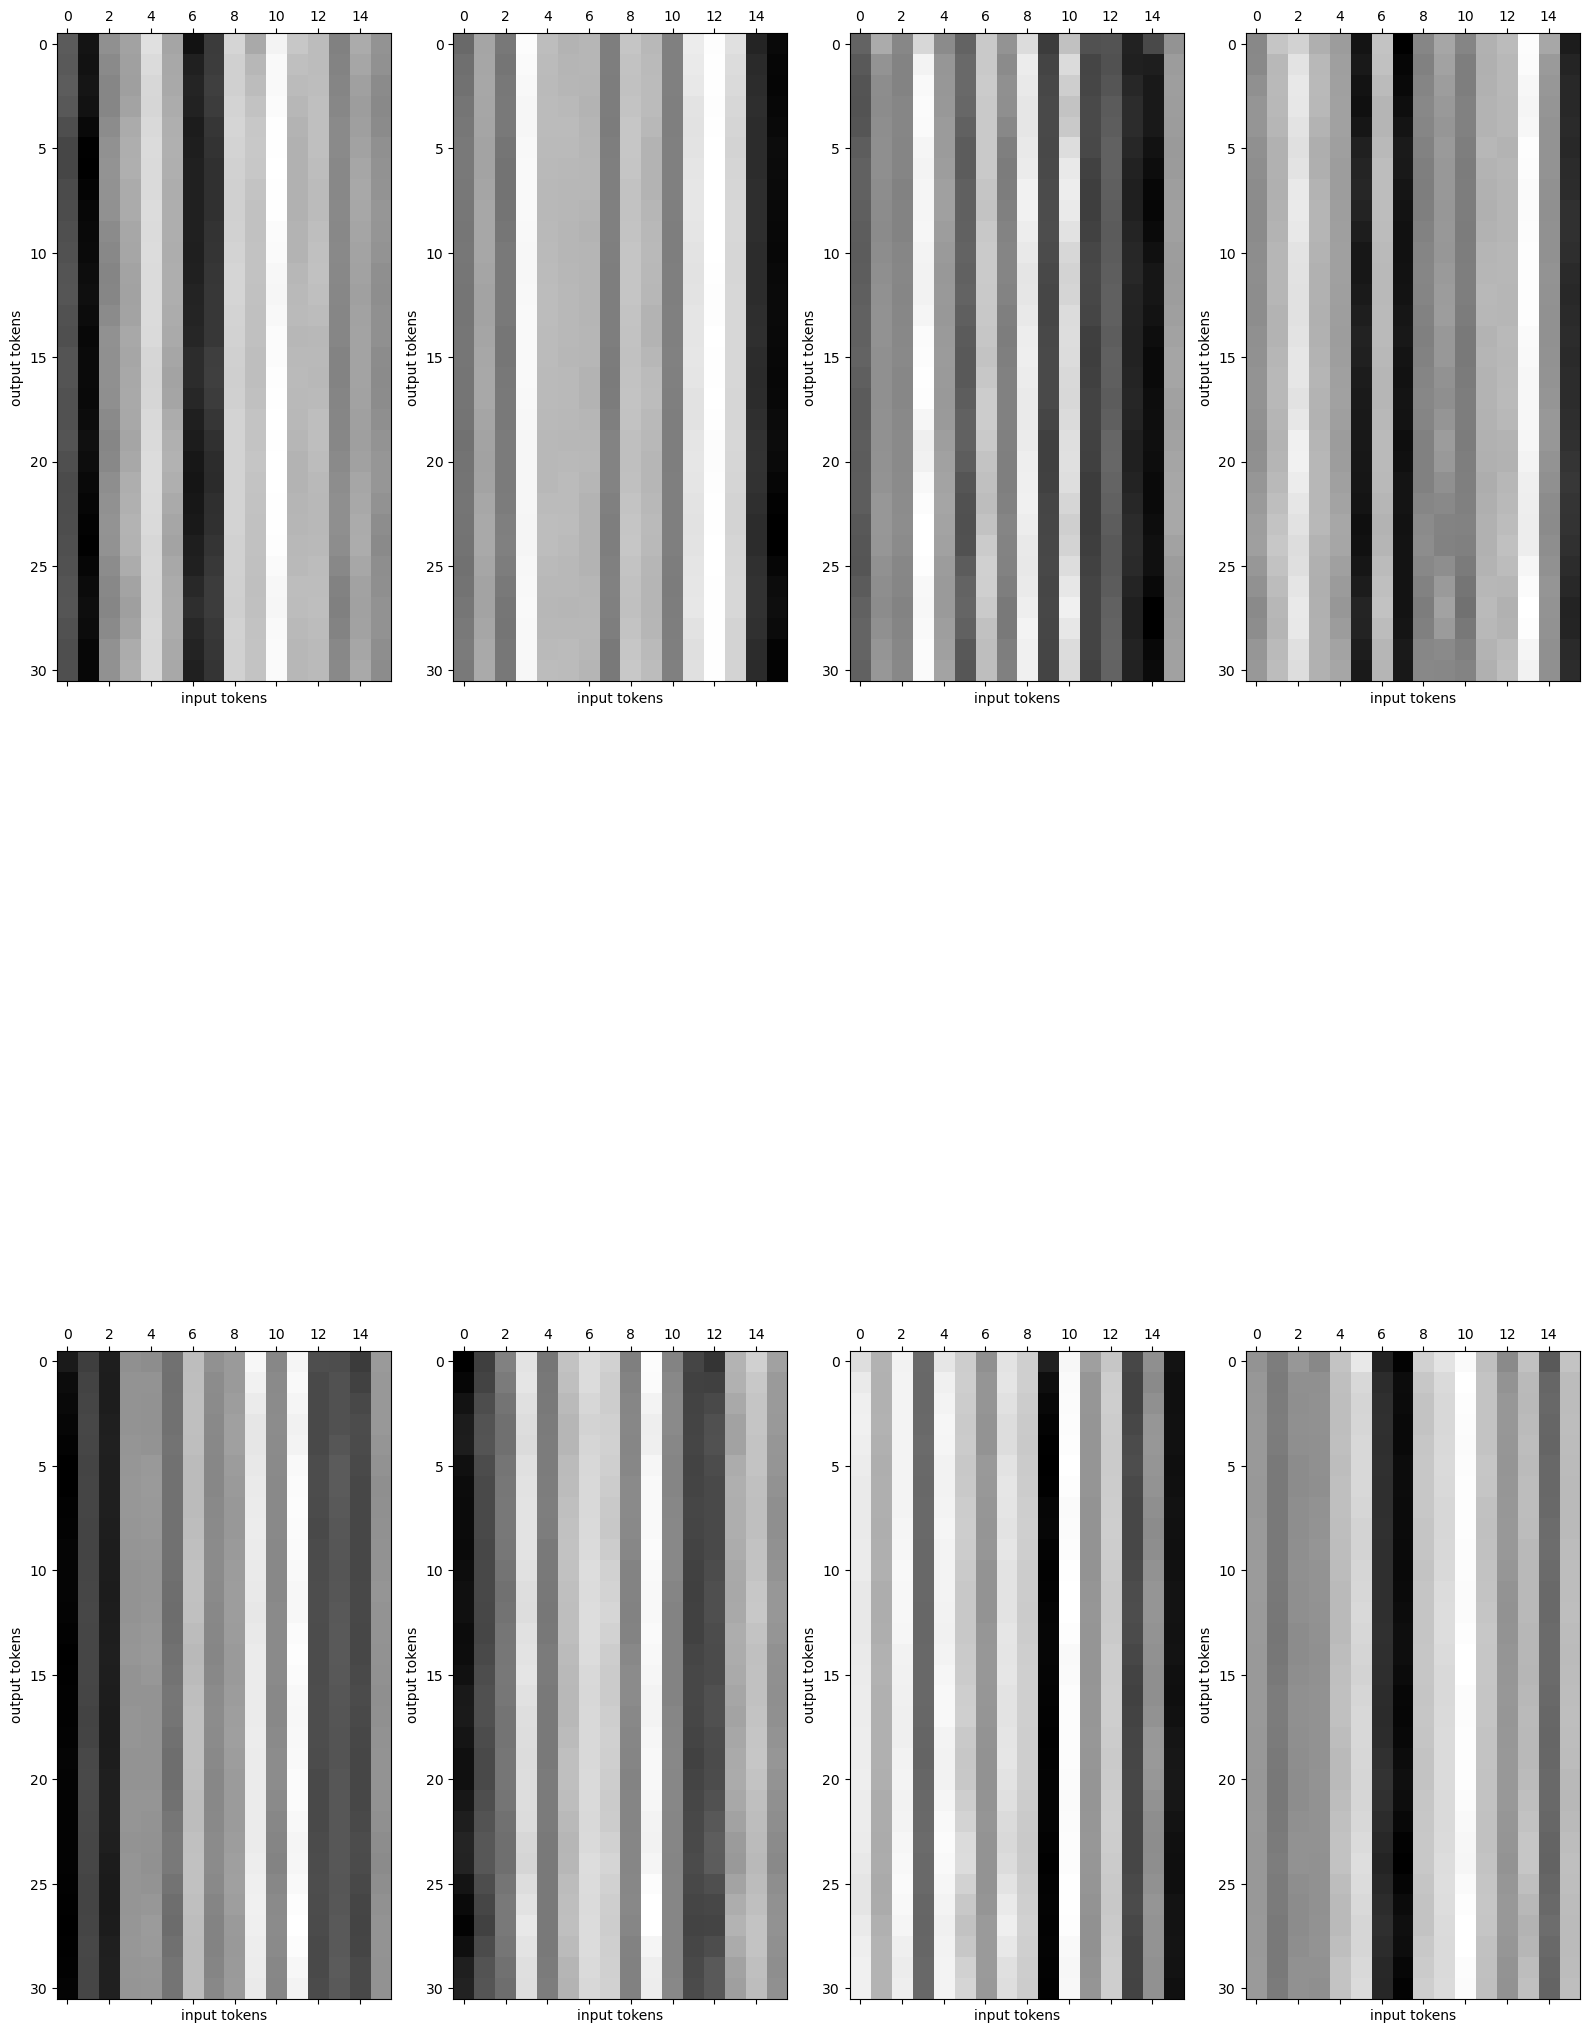

'������������������������������'

In [109]:
translate(model, sentence, plot_attention=True)